# Module 3 Project

## Team Monjon

## Contributors : John Naujoks, Mando Iwanaga

----

**Import necessary packages**

In [253]:
# General setup
import pandas as pd
import numpy as np
import re
import itertools

# Preprocessing and scoring
from ast import literal_eval
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, StandardScaler, MultiLabelBinarizer
from sklearn_pandas import DataFrameMapper, gen_features

# Modeling tools
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Scoring
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, average_precision_score
from sklearn.metrics import log_loss, roc_auc_score, classification_report
from sklearn.decomposition import PCA


# Visualization
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO 
from IPython.display import Image  
from sklearn import tree
import pydotplus
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# EDA and Data Cleaning with scrape of 2015-2019 Data
***

**We obtained our dataset through a combination of using boardgamegeek API Python package<br> and scraping  the boardgamegeek website for missing and additional data.**

In [254]:
# Complete dataset is saved in data folder as bgg_complete_1419.csv
bgg = pd.read_csv('data/bgg_complete_1419.csv', 
                   index_col=0,
                   converters={"mechanic": literal_eval, "category": literal_eval} )

In [255]:
bgg.head()

rank      id                            name  age  avg_time  \
0      NaN  246783     Wildlands: The Unquiet Dead   14        60   
1  12558.0  205776                Gentleman's Deal   12        60   
2  13663.0  188129               Heroes and Tricks    8        25   
3  13323.0  206083  Ragers: Champions of the Arena   14        20   
4   6390.0  201006                         Bumúntú    8        30   

   min_players  max_players  \
0            2            4   
1            5            9   
2            2            6   
3            2            2   
4            2            5   

                                            mechanic  \
0                                                 []   
1                             [Partnerships, Voting]   
2                    [Hand Management, Trick-taking]   
3  [Rock-Paper-Scissors, Simultaneous Action Sele...   
4                    [Action / Movement Programming]   

                                category  weight  year   geek   avg  num_rev  
0  [Expansion for Base-game, Miniatures]     2.0  2018  5.653  7.44    108.0  
1    [Bluffing, Negotiation, Party Game]     1.0  2016  5.514  6.21     47.0  
2                   [Deduction, Fantasy]     0.0  2017  5.504  5.67     83.0  
3         [Card Game, Fantasy, Fighting]     1.0  2016  5.507  5.98     36.0  
4                 [Animals, Educational]     2.0  2019  5.603  7.15     95.0

In [256]:
# Drop rows with no rank, as they are expansions to games, and not individual games
to_drop = bgg[bgg['rank'].isna()]
bgg.drop(to_drop.index, axis=0, inplace=True)
len(bgg)

3142

In [257]:
# Filling in median value for rows with 0 weight given
bgg.loc[bgg["weight"] == 0] = bgg['weight'].median()

In [258]:
# Double checking that it pulled only those for the correct year
len(bgg[bgg['year'] > 2015]), len(bgg)

(2215, 3142)

In [259]:
# Dropping rows with dates prior to 2015 (bad API pull)
to_drop = bgg[bgg['year'] < 2015]
bgg.drop(to_drop.index, axis=0, inplace=True)

In [260]:
len(bgg)

2986

In [261]:
bgg.describe()

rank             id          age       avg_time  min_players  \
count   2986.000000    2986.000000  2986.000000    2986.000000  2986.000000   
mean    5627.139652  199141.554588    10.568989     125.158741     1.877763   
std     3892.970305   34978.264744     3.419438    2210.236276     0.693686   
min        1.000000   16271.000000     0.000000       0.000000     0.000000   
25%     2452.500000  176533.500000     8.000000      30.000000     1.000000   
50%     5066.500000  197185.000000    12.000000      50.000000     2.000000   
75%     7925.500000  225122.250000    13.000000      90.000000     2.000000   
max    17135.000000  272409.000000    21.000000  120000.000000     8.000000   

       max_players       weight         year         geek          avg  \
count  2986.000000  2986.000000  2986.000000  2986.000000  2986.000000   
mean      5.687207     2.185205  2016.504689     5.844739     6.967579   
std      20.202906     0.777614     1.194408     0.459034     0.757621   
min       0.000000     1.000000  2015.000000     4.779000     2.440000   
25%       4.000000     1.600000  2015.000000     5.565000     6.510000   
50%       4.000000     2.062500  2016.000000     5.653000     6.960000   
75%       5.000000     2.708300  2017.000000     5.940000     7.430000   
max     999.000000     5.000000  2019.000000     8.610000     9.600000   

            num_rev  
count   2986.000000  
mean     844.825184  
std     2586.059547  
min       30.000000  
25%       92.000000  
50%      190.000000  
75%      539.500000  
max    51149.000000

In [262]:
len(bgg[bgg['num_rev'] < 50])

255

In [263]:
# Removing rows with less than 50 reviews
to_drop = bgg[bgg['num_rev'] < 50]
bgg.drop(to_drop.index, axis=0, inplace=True)

In [264]:
bgg.reset_index(inplace=True)
bgg.drop('index', axis=1, inplace=True)
bgg.head()

rank        id                      name   age  avg_time  min_players  \
0  6390.0  201006.0                   Bumúntú   8.0      30.0          2.0   
1  3426.0  256839.0                 VektoRace  12.0     120.0          2.0   
2  6801.0  258104.0  Tribes: Dawn of Humanity  10.0      45.0          2.0   
3  5451.0  241796.0               Nut So Fast   8.0      20.0          3.0   
4  9524.0  233206.0                Werebeasts   8.0      15.0          3.0   

   max_players                                     mechanic  \
0          5.0              [Action / Movement Programming]   
1          4.0  [Action / Movement Programming, Simulation]   
2          4.0              [Grid Movement, Tile Placement]   
3          6.0                        [Pattern Recognition]   
4         10.0                             [Set Collection]   

                                            category  weight    year   geek  \
0                             [Animals, Educational]  2.0000  2019.0  5.603   
1                                   [Racing, Sports]  2.3333  2018.0  5.785   
2  [Ancient, Civilization, Exploration, Prehistor...  2.4000  2018.0  5.590   
3                   [Action / Dexterity, Party Game]  1.0000  2018.0  5.636   
4                            [Deduction, Party Game]  1.5000  2018.0  5.543   

    avg  num_rev  
0  7.15     95.0  
1  8.32    196.0  
2  6.80     99.0  
3  7.03    157.0  
4  6.30     94.0

Our dataset is clean, but I'm going to attempt some feature engineering to see if it can help yield I higher performance model. First, lets look at the 'age' column:

In [265]:
len(bgg[bgg.weight < 1]), len(bgg[(bgg.weight > 1) & (bgg.weight <= 2)])

(0, 1147)

In [266]:
def play_time(time):
    if time <=30:
        return "less_than_30"
    elif (time > 30) & (time <=60):
        return "30_to_60"
    elif (time > 60) & (time <=120):
        return "60_to_120"
    else:
        return "120_plus"

bgg['play_time'] = bgg.avg_time.apply(play_time)

In [267]:
len(bgg[bgg.avg_time <= 30]), len(bgg[(bgg.avg_time > 30) & (bgg.avg_time <= 60)]), len(bgg[(bgg.avg_time > 60) & (bgg.avg_time <= 120)]), len(bgg[bgg.avg_time > 120])

(954, 904, 651, 222)

In doing some research, I found this value is a tricky and often guessed value by game makers. It can be hard to say what ages a game is for, other than based on the appropriateness of the content, and even that is subjective. In some of my modeling, it proved to be useful, but as you can see it might just be rewarding those significantly larger grouped games (12, 13, 14). 

---

### Prep for Modeling

In [268]:
bgg['geek'].describe()

count    2731.000000
mean        5.873798
std         0.469515
min         4.779000
25%         5.582000
50%         5.676000
75%         5.989000
max         8.610000
Name: geek, dtype: float64

Here we created a feature called 'top_score' using the geek score. The top 25% will be 1 and the rest will be 0. This feature will be our target for testing.

In [269]:
bgg['top_score'] = bgg['geek'].apply(lambda x: 1 if x > 5.989000 else 0)

In [270]:
bgg.columns

Index(['rank', 'id', 'name', 'age', 'avg_time', 'min_players', 'max_players',
       'mechanic', 'category', 'weight', 'year', 'geek', 'avg', 'num_rev',
       'play_time', 'top_score'],
      dtype='object')

In [271]:
# Define which predictors to drop
to_drop = ['rank','avg_time', 'id', 'name', 'year', 'geek', 'avg', 'num_rev']

In [272]:
bgg.drop(to_drop, axis=1, inplace=True)

In [273]:
bgg.head()

age  min_players  max_players  \
0   8.0          2.0          5.0   
1  12.0          2.0          4.0   
2  10.0          2.0          4.0   
3   8.0          3.0          6.0   
4   8.0          3.0         10.0   

                                      mechanic  \
0              [Action / Movement Programming]   
1  [Action / Movement Programming, Simulation]   
2              [Grid Movement, Tile Placement]   
3                        [Pattern Recognition]   
4                             [Set Collection]   

                                            category  weight     play_time  \
0                             [Animals, Educational]  2.0000  less_than_30   
1                                   [Racing, Sports]  2.3333     60_to_120   
2  [Ancient, Civilization, Exploration, Prehistor...  2.4000      30_to_60   
3                   [Action / Dexterity, Party Game]  1.0000  less_than_30   
4                            [Deduction, Party Game]  1.5000  less_than_30   

   top_score  
0          0  
1          0  
2          0  
3          0  
4          0

In [275]:
num_features = gen_features(
         columns=[['age'],['weight'], ['min_players'], ['max_players'], ['top_score']],
         classes=[None])

cat_features = gen_features(
         columns=['category', 'mechanic', ['play_time']],
         classes=[MultiLabelBinarizer])

combo = num_features + cat_features

map = DataFrameMapper(combo,df_out=True)

bgg_map_df = map.fit_transform(bgg)

In [276]:
bgg_map_df.head()

age  weight  min_players  max_players  top_score  \
0   8.0  2.0000          2.0          5.0          0   
1  12.0  2.3333          2.0          4.0          0   
2  10.0  2.4000          2.0          4.0          0   
3   8.0  1.0000          3.0          6.0          0   
4   8.0  1.5000          3.0         10.0          0   

   category_Abstract Strategy  category_Action / Dexterity  \
0                           0                            0   
1                           0                            0   
2                           0                            0   
3                           0                            1   
4                           0                            0   

   category_Adventure  category_Age of Reason  category_American Civil War  \
0                   0                       0                            0   
1                   0                       0                            0   
2                   0                       0                            0   
3                   0                       0                            0   
4                   0                       0                            0   

   ...  mechanic_Trading  mechanic_Trick-taking  \
0  ...                 0                      0   
1  ...                 0                      0   
2  ...                 0                      0   
3  ...                 0                      0   
4  ...                 0                      0   

   mechanic_Variable Phase Order  mechanic_Variable Player Powers  \
0                              0                                0   
1                              0                                0   
2                              0                                0   
3                              0                                0   
4                              0                                0   

   mechanic_Voting  mechanic_Worker Placement  play_time_120_plus  \
0                0                          0                   0   
1                0                          0                   0   
2                0                          0                   0   
3                0                          0                   0   
4                0                          0                   0   

   play_time_30_to_60  play_time_60_to_120  play_time_less_than_30  
0                   0                    0                       1  
1                   0                    1                       0  
2                   1                    0                       0  
3                   0                    0                       1  
4                   0                    0                       1  

[5 rows x 145 columns]

In [277]:
# Define our X and y 
X = bgg_map_df.drop('top_score', axis=1).copy()
y = bgg_map_df['top_score']

In [278]:
# Train-test split and setting a random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=66)

*** 

## Modeling

**We will try several classification models for comparisons**

---

## Logistic Regression

In [279]:
logreg = LogisticRegression(solver='liblinear', penalty="l1") 

logreg.fit(X_train, y_train)

y_score = logreg.predict_proba(X_test)

**Evaluate Logistic Regression**

Log loss: 0.50356073978574

ROC AUC Score: 0.723715359977719


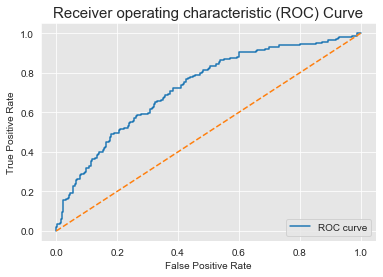

In [280]:
print(f"Log loss: {log_loss(y_test, y_score)}")
print(f"\nROC AUC Score: {roc_auc_score(y_test, y_score[:,1])}")
fpr, tpr, thresholds = roc_curve(y_test, y_score[:,1])
#Plot
plt.plot(fpr, tpr, label='ROC curve')
# this is just a diagonal
plt.plot([0, 1], [0, 1], linestyle='--');
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('Receiver operating characteristic (ROC) Curve', fontsize=15)
plt.show;

In [281]:
# Checking the Cross Validation Score
cross_val_logreg = cross_val_score(logreg, X, y, cv=5)
print(cross_val_logreg)
print(f"Average of Cross val scores: {sum(cross_val_logreg/len(cross_val_logreg))}")

[0.78427788 0.76739927 0.75641026 0.67765568 0.73260073]
Average of Cross val scores: 0.7436687626815597


----

## Decision Tree

In [282]:
# Set random seed for reproducibility
np.random.seed(123)

clf = DecisionTreeClassifier()

clf.fit(X_train, y_train)

y_pred_t = clf.predict_proba(X_test)

In [283]:
# Print feature importance percentages to explore how it performed.

vals = clf.feature_importances_.tolist()
best = []
for i, val in enumerate(vals):
    if round(val * 100, 2) > 1:
        print(X.columns[i] + ": " + str(round(val * 100, 2)) + "%")
        best.append(val)

age: 5.49%
weight: 23.95%
min_players: 4.25%
max_players: 3.23%
category_City Building: 1.17%
category_Fighting: 1.04%
category_Science Fiction: 1.79%
mechanic_Action Point Allowance System: 1.57%
mechanic_Area Control / Area Influence: 1.42%
mechanic_Card Drafting: 1.66%
mechanic_Deck / Pool Building: 1.05%
mechanic_Dice Rolling: 1.48%
mechanic_Hand Management: 1.54%
mechanic_Hex-and-Counter: 1.32%
mechanic_Role Playing: 1.05%
mechanic_Storytelling: 1.44%
mechanic_Tile Placement: 1.51%
mechanic_Variable Player Powers: 1.07%
play_time_60_to_120: 1.53%


**Evaluate Decision Tree**

Log loss: 10.11587346023903

ROC AUC Score: 0.6146834238499744


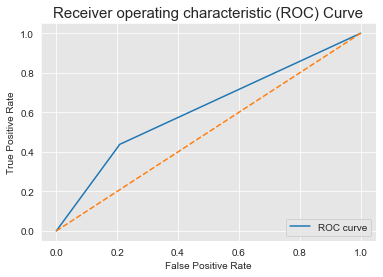

In [284]:
# Seaborn's beautiful styling
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

print(f"Log loss: {log_loss(y_test, y_pred_t)}")
print(f"\nROC AUC Score: {roc_auc_score(y_test, y_pred_t[:,1])}")
fpr, tpr, thresholds = roc_curve(y_test, y_pred_t[:,1])
# Plot
plt.plot(fpr, tpr, label='ROC curve')

# This is just a diagonal
plt.plot([0, 1], [0, 1], linestyle='--');
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('Receiver operating characteristic (ROC) Curve', fontsize=15)
plt.show;

**Visualization of Decision Tree**

In [129]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, filled=True, rounded=True,special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [130]:
# Checking the Cross Validation Score
cross_val_clf = cross_val_score(clf, X, y, cv=5)
print(cross_val_clf)
print(f"Average of Cross val scores: {sum(cross_val_clf/len(cross_val_clf))}")

[0.73308958 0.66849817 0.68681319 0.67032967 0.66117216]
Average of Cross val scores: 0.6839805532675733


---

## Random Forest Classifier

In [285]:
np.random.seed(123)

forest = RandomForestClassifier()

forest.fit(X_train, y_train)

y_pred_forest = forest.predict_proba(X_test)
y_pred_f = forest.predict(X_test)

/Users/nawjux/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [286]:
# Print feature importance percentages

vals = forest.feature_importances_.tolist()
best = []
for i, val in enumerate(vals):
    if round(val * 100, 2) > 1:
        print(X.columns[i] + ": " + str(round(val * 100, 2)) + "%")
        best.append(val)

age: 5.86%
weight: 12.27%
min_players: 3.12%
max_players: 4.67%
category_Card Game: 1.86%
category_Dice: 1.2%
category_Economic: 1.31%
category_Fantasy: 1.5%
category_Medieval: 1.01%
category_Science Fiction: 1.16%
mechanic_Action Point Allowance System: 1.07%
mechanic_Area Control / Area Influence: 1.39%
mechanic_Card Drafting: 2.65%
mechanic_Cooperative Play: 1.43%
mechanic_Deck / Pool Building: 1.46%
mechanic_Dice Rolling: 1.56%
mechanic_Hand Management: 1.82%
mechanic_Set Collection: 1.29%
mechanic_Take That: 1.12%
mechanic_Tile Placement: 1.31%
mechanic_Variable Player Powers: 1.78%
mechanic_Worker Placement: 1.26%
play_time_30_to_60: 1.56%
play_time_60_to_120: 1.64%
play_time_less_than_30: 1.26%


**Evaluate Random Forest**

Log loss: 1.1950068473486308

ROC AUC Score: 0.7133755744325303


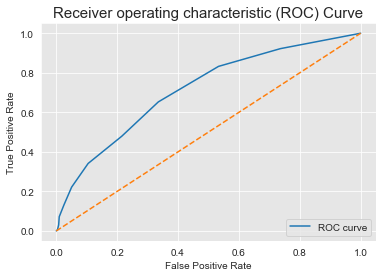

In [287]:
# Seaborn's beautiful styling
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

print(f"Log loss: {log_loss(y_test, y_pred_forest)}")
print(f"\nROC AUC Score: {roc_auc_score(y_test, y_pred_forest[:,1])}")
fpr, tpr, thresholds = roc_curve(y_test, y_pred_forest[:,1])

# Plot of ROC Curve
plt.plot(fpr, tpr, label='ROC curve')

# This is just a diagonal
plt.plot([0, 1], [0, 1], linestyle='--');
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('Receiver operating characteristic (ROC) Curve', fontsize=15)
plt.show;

In [288]:
# Checking the Cross Validation Score
cross_val_forest = cross_val_score(forest, X, y, cv=5)
print(cross_val_forest)
print(f"Average of Cross val scores: {sum(cross_val_forest/len(cross_val_forest))}")

[0.78427788 0.74358974 0.76190476 0.70879121 0.72344322]
Average of Cross val scores: 0.7444013634141604


---

## Gradient Boosting Classifier

In [289]:
np.random.seed(123)

boost = GradientBoostingClassifier(learning_rate=.03, max_depth=4, n_estimators=150)

boost.fit(X_train, y_train)

boost_pred = boost.predict_proba(X_test)
boost_conf_pred = boost.predict(X_test)

In [290]:
#Print feature importance percentages

vals = boost.feature_importances_.tolist()
best = []
for i, val in enumerate(vals):
    if round(val * 100, 2) > 1:
        print(X.columns[i] + ": " + str(round(val * 100, 2)) + "%")
        best.append(val)

age: 4.35%
weight: 37.7%
min_players: 4.72%
max_players: 3.79%
category_Deduction: 1.34%
category_Economic: 1.25%
category_Real-time: 1.82%
category_Spies/Secret Agents: 1.06%
category_Word Game: 1.9%
mechanic_Card Drafting: 4.32%
mechanic_Hex-and-Counter: 3.38%
mechanic_Hidden Traitor: 1.08%
mechanic_Paper-and-Pencil: 1.2%
mechanic_Route/Network Building: 1.22%
mechanic_Set Collection: 1.3%
mechanic_Storytelling: 1.66%
mechanic_Variable Player Powers: 1.87%


**Evaluate Gradient Boosting**

Log loss: 0.45722645970151266

ROC AUC Score: 0.7891774590354175


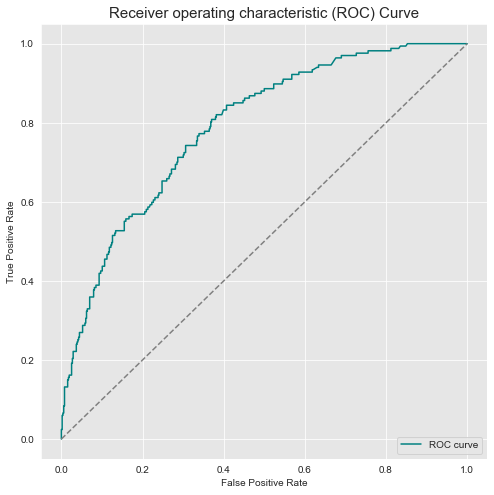

In [291]:
#Seaborn's beautiful styling
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
plt.figure(figsize=(8,8))

print(f"Log loss: {log_loss(y_test, boost_pred)}")
print(f"\nROC AUC Score: {roc_auc_score(y_test, boost_pred[:,1])}")
fpr, tpr, thresholds = roc_curve(y_test, boost_pred[:,1])

#Plot
plt.plot(fpr, tpr, label='ROC curve', color='teal') 

# This is just a diagonal
plt.plot([0, 1], [0, 1], linestyle='--', color='grey');
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('Receiver operating characteristic (ROC) Curve', fontsize=15)
plt.show;
plt.savefig('../rock.png')

In [292]:
# Checking the Cross Validation Score
cross_val_boost = cross_val_score(boost, X, y, cv=5)
print(cross_val_boost)
print(f"Average of Cross val scores: {sum(cross_val_boost/len(cross_val_boost))}")

[0.78244973 0.78021978 0.78388278 0.70879121 0.78205128]
Average of Cross val scores: 0.7674789561444041


---

### Final thoughts
Based on our results, it appears we achieve very similar results with all our models. The Random Forest performed the best, and held up well under cross validation. Gradient Boosting did similar, but with a higher computational cost, I prefer using the Random Forest. I am going to experiment with coming up with some custom features to see if that can help hone in on a better model.

---

## GridSearchCV

**Run GridSearch on models to find the best parameters on the Random Forest Classifier**

In [91]:
param_grid_forest = {
    "n_estimators": [20, 25, 30, 35],
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 3],
    "min_samples_split": [3, 4, 5, 6],
    "min_samples_leaf": [1, 2]
}

In [92]:
gs_forest = GridSearchCV(forest, param_grid_forest, cv=5)

In [93]:
gs_forest.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=10, n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid='wa

In [94]:
gs_forest.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 35}

### Testing our optimum params to create the model

In [95]:
np.random.seed(123)

forest_optimum = RandomForestClassifier(criterion='gini',
                                        max_depth=None,
                                        min_samples_leaf=2,
                                        min_samples_split=5,
                                        n_estimators=35)

forest_optimum.fit(X_train, y_train)

y_pred_forest_optimum = forest.predict_proba(X_test)

Log loss: 1.0086943822120755

ROC AUC Score: 0.7243652230422876


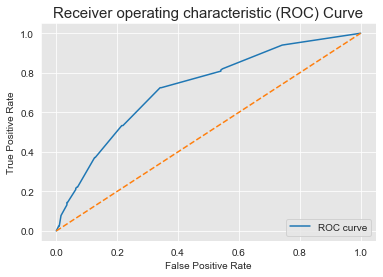

In [96]:
# Seaborn's beautiful styling
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

print(f"Log loss: {log_loss(y_test, y_pred_forest_optimum)}")
print(f"\nROC AUC Score: {roc_auc_score(y_test, y_pred_forest_optimum[:,1])}")
fpr, tpr, thresholds = roc_curve(y_test, y_pred_forest_optimum[:,1])

# Plot of ROC Curve
plt.plot(fpr, tpr, label='ROC curve')

# This is just a diagonal
plt.plot([0, 1], [0, 1], linestyle='--');
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('Receiver operating characteristic (ROC) Curve', fontsize=15)
plt.show;

In [97]:
# Checking the Cross Validation Score
cross_val_forest_optimum = cross_val_score(forest_optimum, X, y, cv=5)
print(cross_val_forest_optimum)
print(f"Average of Cross val scores: {sum(cross_val_forest_optimum/len(cross_val_forest_optimum))}")

[0.7714808  0.75274725 0.77655678 0.70512821 0.76923077]
Average of Cross val scores: 0.7550287616101145
